In [1]:
#todo: check how would the context of soft margin look like, compared to the cell below

### Hard Margin SVM Context:

In SVMs, particularly in the context of hard margin SVMs, the goal is to find a hyperplane that perfectly separates the data points of two classes. The labels are typically represented as $-1$ and $1$ rather than $0$ and $1$ because:

1. **Mathematical Convenience**:
   - Using labels $-1$ and $1$ simplifies the formulation of the optimization problem and the corresponding constraints. The margin can be described uniformly for both classes.
   - The decision function is typically of the form $f(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$, and the classification rule is based on the sign of this function. For a correctly classified point $\mathbf{x}_i$, the product $y_i \cdot f(\mathbf{x}_i)$ should be positive, which leads to the constraint:
     $
     y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1
     $
     This constraint holds naturally when $y_i$ is $-1$ or $1$.

2. **Margin Definition**:
   - The margin is defined as the distance between the closest points (support vectors) and the hyperplane. For a hard margin SVM, this margin is maximized while ensuring that all data points are correctly classified.
   - With the transformation to $-1$ and $1$ labels, the SVM can enforce the hard margin constraint uniformly for both classes without needing additional conditions for different label values.

### The Transformation:
- The transformation $t_i = 2y_i - 1$ maps:
  - $y_i = 0$ to $t_i = -1$
  - $y_i = 1$ to $t_i = 1$

This ensures that the SVM can apply the margin constraints uniformly for both classes, treating them symmetrically in the optimization process.

### In Summary:
The transformation of the labels from $y \in \{0, 1\}$ to $t \in \{-1, 1\}$ is a crucial step in setting up the SVM for hard margin classification. It ensures that the mathematical formulation of the SVM is consistent and simplifies the application of the margin constraints, which are fundamental to the SVM's operation.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# ------------------------------------------------------------------------------------------------
# EXAMPLE 1
Mainly based on the books author's code. But little adjustments were done from my side.

In [3]:
from sklearn import datasets

# CREATE DATA
iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [4]:
X.shape, y.shape

((150, 2), (150,))

In [5]:
# check what unique values are in y
y.unique()

array([False,  True])

In [6]:
y.value_counts()

target
False    100
True      50
Name: count, dtype: int64

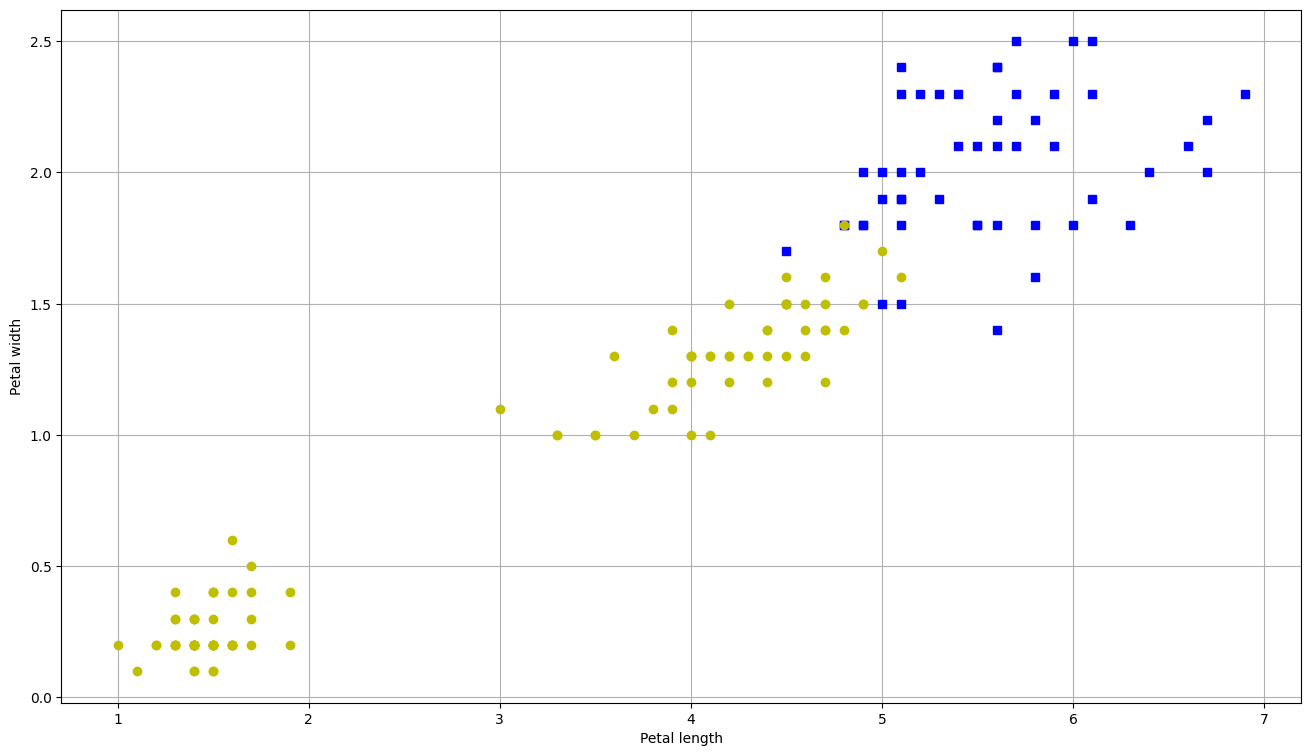

In [7]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")  # blue squares
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")  # yellow circles
plt.xlabel("Petal length")
plt.ylabel("Petal width")
# plt.gca().set_aspect("equal") # make aspect ratio equal of x and y axis
plt.grid()

In [8]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# CREATE ESTIMATOR
from sklearn.base import BaseEstimator
from my_extensions import MySVMBase


class MyLinearSVC(BaseEstimator, MySVMBase):
    def __init__(self, C=1, eta0=1, eta_d=1000, n_epochs=1000):
        """
        This class uses soft margin SVM to classify the data. It uses hinge loss as a loss function.
        This means that if you have parameter "C" then you are using soft margin SVM.
        
        :param C: Regularization parameter 
        :param eta0: Learning rate parameter
        :param eta_d: Learning rate decay parameter 
        :param n_epochs: Number of epochs
        :param random_state: 
        """

        super().__init__()
        self.C = C
        self.eta0 = eta0
        self.eta_d = eta_d
        self.n_epochs = n_epochs
        self.Js = []  # Container for losses
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None

    def eta(self, epoch):
        """
        This function calculates the learning rate at each epoch.
        The greater the epoch, the smaller the learning rate.

        :param epoch: Numer of a epoch in the training process
        :returns: Learning rate
        """
        return self.eta0 / (epoch + self.eta_d)

    @staticmethod
    def transform_datapoints_to_positive_and_negative(X, y):
        """
        This function converts the original y data to column vector and then -1 and 1 from False and True 
        (meaning 0 and 1, because the False is 0 and True is 1)
        and multiplies the feature dataset with the converted y data.
        
        Example (Data do not make sense, important is the conversion):
        X = np.array([[1, 2], [3, 4], [5, 6]])
        y = [True, False, True]
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        X_t, t
        
        Result:
        (array([[ 1.,  2.],
                [-3., -4.],
                [ 5.,  6.]]),
         array([[ 1.],
                [-1.],
                [ 1.]]))
                
        :param X: Feature dataset
        :param y: Labels
        :returns: Converted feature dataset and labels
        """
        t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
        X_t = X * t
        return X_t, t

    def select_margin_violators(self, X_t, t, intercept, coef):
        """
        This function selects the margin violators.
        
        :param X_t: Feature dataset, which in this case is original dataset multiplied by -1 and 1.
        :param t: Labels, which are either -1 or 1.

        Returns:

        """
        support_vectors_idx = (X_t.dot(coef) + t * intercept < 1).ravel()
        X_t_sv = X_t[support_vectors_idx]
        t_sv = t[support_vectors_idx]

        return X_t_sv, t_sv, support_vectors_idx

    def fit(self, X, y):
        """
        This function fits the model to the training data. It returns "self" due 
        to the convenient way like

        chaining: 
        "model = SomeModel().fit(X, y).predict(X_test)" 

        or in pipeline:
        "from sklearn.pipeline import Pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', SomeModel())
        ])
        pipeline.fit(X_train, y_train)"


        :param X: Feature dataset
        :param y: Labels
        :returns: self
        """
        # Random initialization of weights and bias
        coef_ = np.random.randn(X.shape[1], 1)  # number of feature weights
        intercept_ = 0

        X_t, t = self.transform_datapoints_to_positive_and_negative(X, y)

        # Training
        for epoch in range(self.n_epochs):
            X_t_sv, t_sv, _ = self.select_margin_violators(X_t, t, intercept_, coef_)

            # Losses (Just for visualisation) --------------------------------
            J = 1 / 2 * (coef_ * coef_).sum() + self.C * (
                    (1 - X_t_sv.dot(coef_)).sum() - intercept_ * t_sv.sum())
            self.Js.append(J)
            # ----------------------------------------------------------------

            # compute gradients
            w_gradient_vector = coef_ - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
            b_derivative = -(self.C) * t_sv.sum()

            # update weights and bias
            eta = self.eta(epoch)
            coef_ = coef_ - eta * w_gradient_vector
            intercept_ = intercept_ - eta * b_derivative

        _, _, support_vectors_idx = self.select_margin_violators(X_t, t, intercept_, coef_)
        self.intercept_ = np.array([intercept_])
        self.coef_ = np.array([coef_])
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return self.decision_function(X) >= 0

In [11]:
# TRAIN MODEL
C = 1
eta0 = 1
eta_d = 1000
n_epochs = 1000
svm1 = MyLinearSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs)

In [12]:
svm1.fit(X_train, y_train)

MyLinearSVC()

In [13]:
print(svm1.show_parameters())

coef_:
[[[1.71042808]
  [2.2234113 ]]]

intercept_:
[-2.44931194]

support_vectors_:
[[0.70592084 0.92230284]
 [0.42173371 0.3957741 ]
 [0.76275827 0.92230284]
 [0.42173371 0.52740629]
 [0.53540856 0.3957741 ]
 [0.76275827 0.3957741 ]
 [0.42173371 0.3957741 ]
 [0.64908342 0.79067065]
 [0.59224599 0.79067065]
 [0.76275827 0.92230284]
 [0.42173371 0.3957741 ]
 [0.70592084 0.65903847]
 [0.59224599 0.79067065]
 [0.76275827 0.52740629]
 [1.0469454  0.26414192]
 [0.70592084 0.3957741 ]
 [0.64908342 0.3957741 ]
 [0.53540856 0.26414192]
 [0.47857113 0.3957741 ]
 [0.59224599 0.79067065]
 [0.53540856 0.26414192]
 [1.16062026 0.52740629]
 [0.64908342 0.3957741 ]
 [0.76275827 0.79067065]
 [0.42173371 0.65903847]]


In [14]:
# EVALUATE MODEL
from sklearn.metrics import accuracy_score

y_pred = svm1.predict(X_test)
y_pred.shape, y_test.shape


((30, 1), (30,))

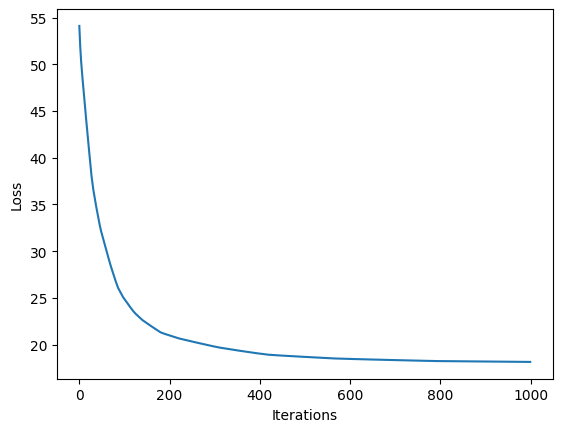

In [15]:
svm1.show_loss_curve()

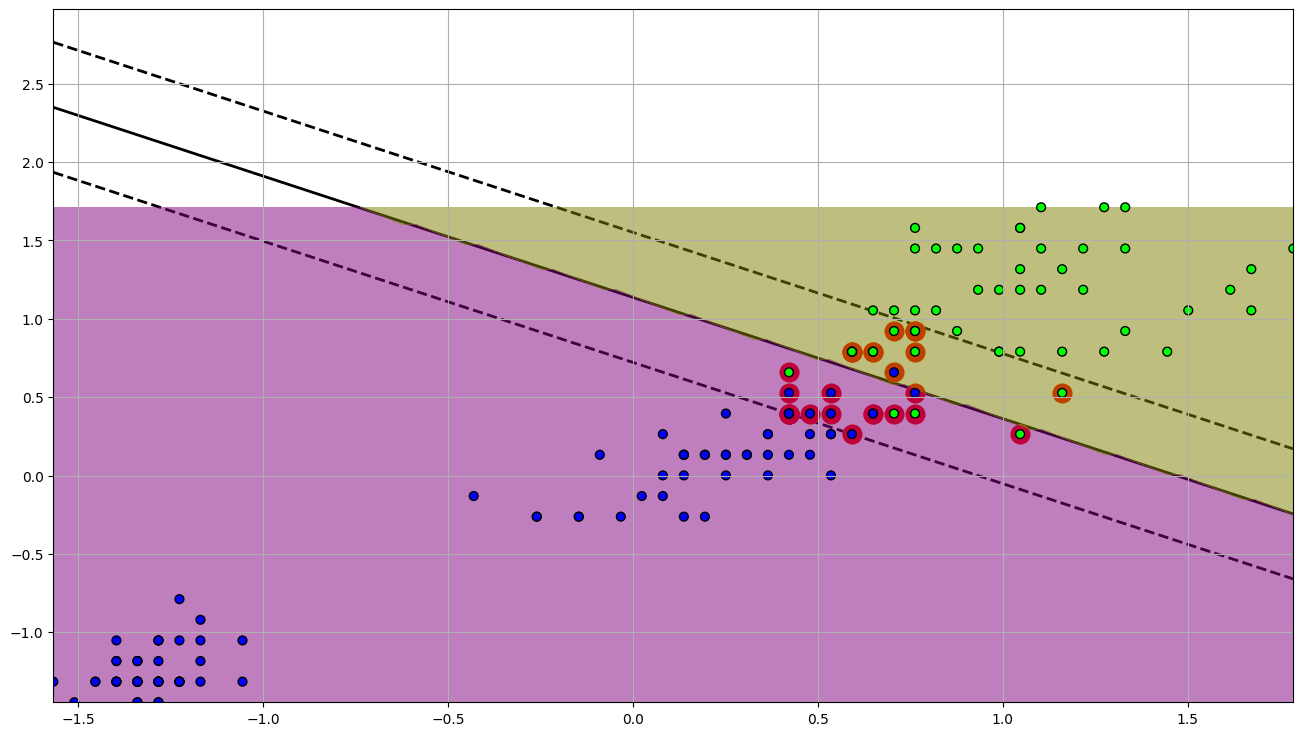

In [16]:
from data_plotting import Plots

plot1 = Plots()
plot1.plot_decision_boundary(MyLinearSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs), X_scaled, y,
                             support_vectors=True)

In [17]:
# Cross validation
from sklearn.model_selection import cross_val_score

# The aim was to show you that some observations are misclassified. Meaning some are on the
# other side of the decision boundary. But it really depends on how the dataset is split since
# there are only a few datapoints the complete dataset.

scores = cross_val_score(svm1, X_test, y_test, cv=5, scoring="accuracy")
scores


array([1.        , 1.        , 1.        , 0.83333333, 1.        ])

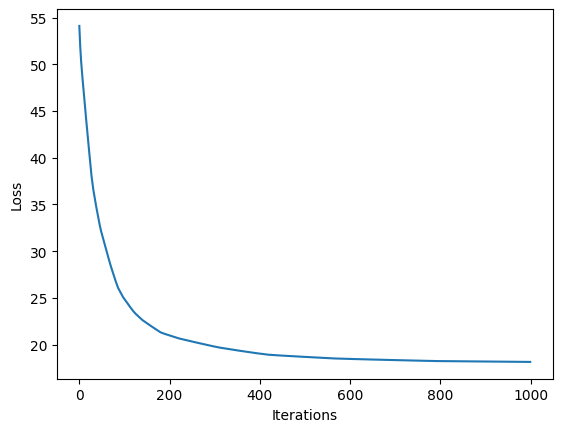

In [18]:
svm1.show_loss_curve()

# ------------------------------------------------------------------------------------------------
# EXAMPLE 2
My fiddling around with the code.

In [19]:
# CREATE DATA
from sklearn.datasets import make_blobs

# X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=4)
X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=2)
# X, y = make_blobs(n_samples=1000, centers=2, random_state=42, cluster_std=1)

In [20]:
X[:10]

array([[-0.8378134 ,  6.75487242],
       [ 7.99528046,  0.8659932 ],
       [ 2.44732866, -0.90693208],
       [ 5.68554981,  0.82576968],
       [ 4.27891901,  8.35938482],
       [ 6.5902741 ,  2.97535802],
       [ 5.81326644,  1.02336237],
       [-2.11615528, 10.43229364],
       [ 2.69656537, -0.78606665],
       [-2.57545157, 12.60340186]])

In [21]:
y[:10]

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0])

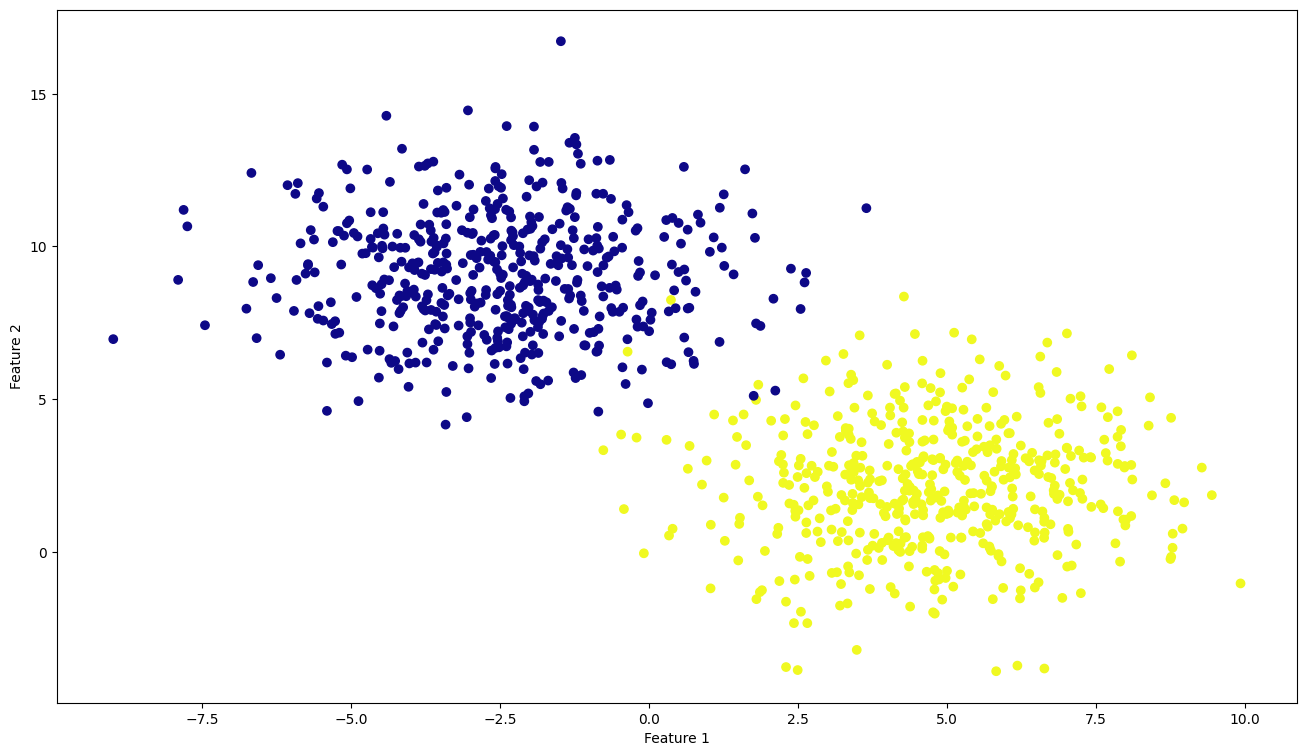

In [22]:
plt.figure(figsize=(16, 9))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [23]:
# SCALE DATA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# SPLIT DATA
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
# TRAIN MODEL
C = 1
eta0 = 1
eta_d = 1000
n_epochs = 1000
svm2 = MyLinearSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs)
svm2.fit(X_train, y_train)

MyLinearSVC()

In [41]:
# EVALUATE MODEL
y_pred = svm2.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [42]:
svm2.intercept_, svm2.coef_

(array([0.05075907]),
 array([[[ 2.08586877],
         [-2.30676266]]]))

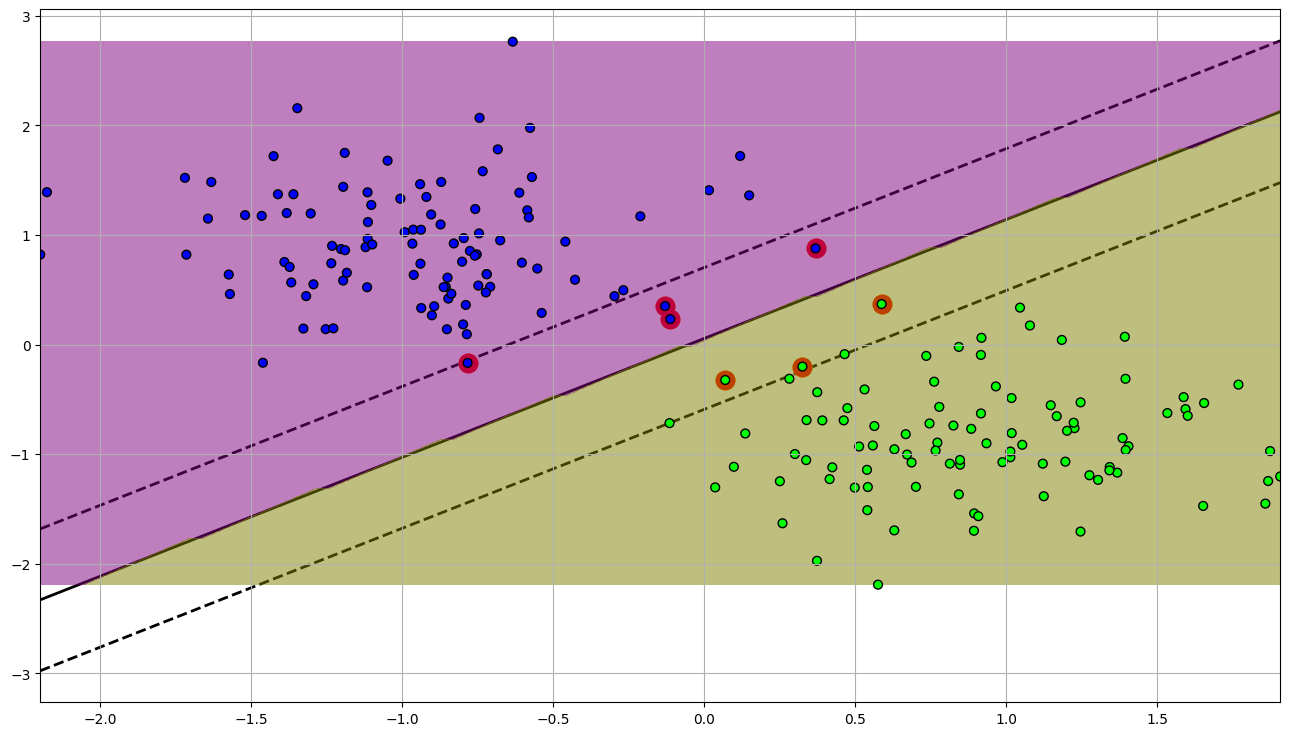

In [43]:
plot2 = Plots()
plot2.plot_decision_boundary(MyLinearSVC(C=C, eta0=eta0, eta_d=eta_d, n_epochs=n_epochs), X_test, y_test,
                             support_vectors=True)

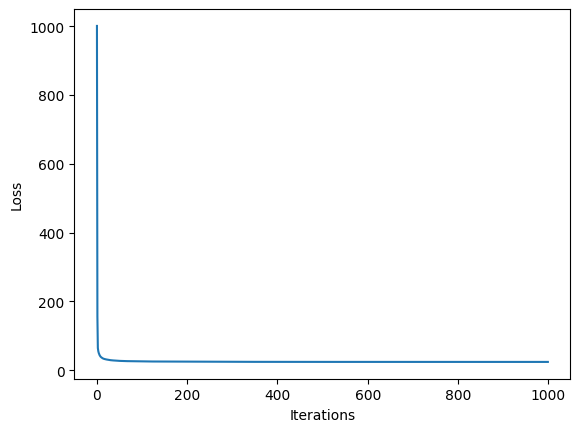

In [44]:
svm2.show_loss_curve()